In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

def normpdf(x, loc=0, scale=1):
    return 1 / np.sqrt(2*np.pi) / scale * np.exp(-(x-loc)**2 / 2 / scale**2)

def normlogpdf(x, loc=0, scale=1):
    return np.log(1 / np.sqrt(2*np.pi) / scale) - (x-loc)**2 / 2 / scale**2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# specify the value of m1 and m2
m1m2 = [1, 1]

k_base = 1e-8
range_k_log = [2, 6]
range_m = [0, 2]
range_r = [1/3.0, 0]
noise_scale_base = 0.0096
noise_scale_ratio = 0.
    
def get_init_species(init_c):
    O1 = init_c[0]
    O2 = 0.0
    O3 = 0.0
    Cr = init_c[1]
    return np.array([O1, O2, O3, Cr])

# RK4 to simulate decay model
def get_species(k1_log, k2_log, m1, m2, r7, init_c, n_data):
    k1 = 10**(k1_log) * k_base
    k2 = 10**(k2_log) * k_base
    specie = get_init_species(init_c)
    specie[-1] -= r7 * specie[0]
    species = [specie]
    A_inv = np.eye(3)
    b = np.zeros(3)
    for t in range(n_data):
        specie_old = np.copy(specie)[:3]
        dspecies = []
        for tt in range(4):
            b[:] = [-k1*specie[0]**m1, k1*specie[0]**m1 - k2*specie[1]**m2,
                    k2*specie[1]**m2]
            dspecie = A_inv.dot(b)
            dspecies.append(dspecie)
            if tt in (0, 1):
                specie = specie_old + dspecie * dt / 2
            elif tt == 2:
                specie = specie_old + dspecie * dt
            else:
                specie = specie_old + (dspecies[0] + 2 * dspecies[1] 
                                       + 2 * dspecies[2] + dspecies[3]) * dt / 6
        O1, O2, O3 = specie
        specie = np.append(specie, init_c[1] - r7 * O1 - r7 * O2 * 2 - r7 * O3 * 3)
        species.append(specie.copy())
    return np.array(species)

def get_spectra(k_log, m, r7):
    k1_log, k2_log = k_log
    m1, m2 = m
    spectra = np.array([])
    for k in range(n_set):
        species = get_species(k1_log, k2_log, m1, m2, r7, init_cs[k], n_datas[k])
        Cr = species[:, -1]
        tf = (Cr >= cs_Cr[1]).astype(int)
        sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
        spectra = np.append(spectra, sp_Cr.flatten())
    
    return spectra

def get_spectra_noise(g):
    return noise_scale_base + noise_scale_ratio * np.abs(g)

In [13]:
# load standard spectrum of Cr
data_Cr = np.load('../spectra/7+.npy', allow_pickle=True).item()
cs_Cr = np.array(list(data_Cr.keys()))
sps_Cr = list(data_Cr.values())

# load spectra
n_set = 4
init_cs = (
    (
        0.2, # BQDS 
        0.4  # K2Cr2O7
    ),
    (
        0.25,
        0.4
    ),
    (
        0.2,
        0.5
    ),
    (
        0.3,
        0.5
    )
)
file_names = ["../spectra/0.4 mM K2Cr2O7 0.2 mM BQDS/03 0.2 mM BQDS 0.4 mM K2Cr2O7 1 M H2SO4 5 min_Absorbance",
              "../spectra/0.4 mM K2Cr2O7 0.25 mM BQDS/03 0.4 mM K2Cr2O7 0.25 M BQDS 1 M H2SO4 5 min_Absorbance",
              "../spectra/0.5 mM K2Cr2O7 0.2 mM BQDS/03 0.5 mM K2Cr2O7 0.2 mM BQDS 1 M H2SO4 5 min_Absorbance",
              "../spectra/0.5 mM K2Cr2O7 0.3 mM BQDS/03 0.5 mM K2Cr2O7 0.3 mM BQDS 1 M H2SO4 5 min_Absorbance"]
zeros = [3, 4, 4, 4]
n_datas = [288, 280, 88, 224]

dt = 5 * 60
idxs = [437]
spectras = []
data = np.array([])
for k in range(n_set):
    spectra = []
    for i in range(n_datas[k] + 1):
        if zeros[k] == 3:
            file = open(file_names[k] + "_{:03}.txt".format(i))
        elif zeros[k] == 4:
            file = open(file_names[k] + "_{:04}.txt".format(i))
        lines = file.readlines()[14:]
        spectrum = []
        for d in lines:
            tmp = d.split()
            for j in range(len(tmp)):
                tmp[j] = float(tmp[j])
            spectrum.append(tmp)
        spectra.append(spectrum)
    spectra = np.array(spectra)
    spectras.append(spectra)
    data = np.append(data, spectra[:, idxs, 1].flatten())
sps_Cr = np.array([sp[idxs, 1] for sp in sps_Cr])
data[643] = (data[642] + data[644]) / 2.0

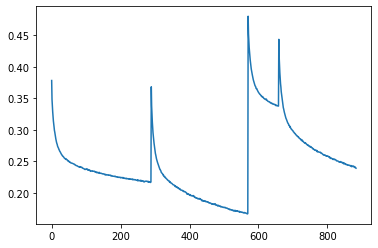

In [14]:
plt.plot(data)

In [15]:
def generate_prior():
    k_log = np.random.uniform(*range_k_log, 2)
    m = np.copy(m1m2)
    r7 = 1 / 3.0
    return k_log, m, r7

def get_likeli(*args):
    interval = 10
    g = get_spectra(*args)[::interval]
    noise = get_spectra_noise(g)
    loglikeli = normlogpdf(g, data[::interval], noise)
    return np.exp(loglikeli.sum())

In [16]:
np.random.seed(1)
likelis = []
n_sample = 0
evid = 0
evids = []
while n_sample <= 1e6:
    n_sample += 1
    prior = generate_prior()
    likeli = get_likeli(*prior)
    if np.isnan(likeli):
        n_sample -= 1
        continue
    likelis.append(likeli)
    evid += likeli
    if n_sample % 100 == 0:
        print(n_sample, evid / n_sample)
        evids.append(evid / n_sample)

100 9.203576551602839e+124
200 4.609983328496981e+124


KeyboardInterrupt: 

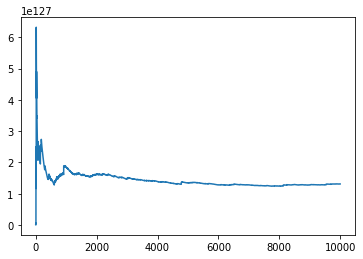

In [7]:
plt.plot(evids)

In [8]:
np.save(f'O1O2O3_M={m1m2[0]}{m1m2[1]}', evids)

In [8]:
evids = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        evid = np.load(f'O1O2O3_350nm_fixR_M={i}{j}.npy')[-1]
        evids[i][j] = evid
evids = evids / evids.sum()

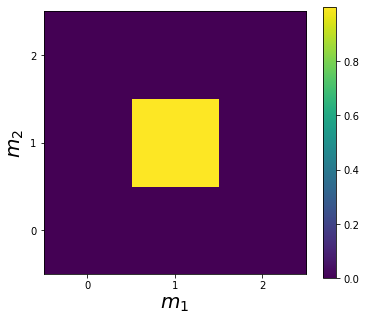

In [9]:
plt.figure(figsize=(20,5))
for i in range(1):
    plt.subplot(1, 3, i+1)
    plt.imshow(evids.T, origin='lower')
    plt.xlabel('$m_1$', fontsize=20)
    plt.ylabel('$m_2$', fontsize=20)
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1), minor=False);
    ax.set_yticks(np.arange(0, 3, 1), minor=False);
    ax.set_xticklabels([0,1,2])
    ax.set_yticklabels([0,1,2])
    plt.colorbar()
# #     plt.scatter(m_true[draw_idx[0]-3]-1, m_true[draw_idx[1]-3]-1, c='red')
    plt.xlim(range_m[0]-0.5, range_m[1]+0.5)
    plt.ylim(range_m[0]-0.5, range_m[1]+0.5)
#     plt.scatter(trace['m'][idx, 0], trace['m'][idx, 1], c='orangered')
plt.savefig('chromium_m_evid_350nm_fixR.pdf', bbox_inches='tight')

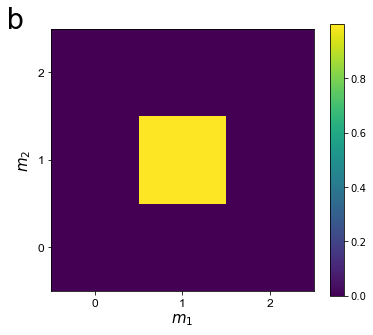

In [107]:
plt.figure(figsize=(20,5))
for i in range(1):
    plt.subplot(1, 3, i+1)
    plt.imshow(evids.T, origin='lower')
    plt.xlabel('$m_1$', fontsize=15)
    plt.ylabel('$m_2$', fontsize=15)
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 3, 1), minor=False);
    ax.set_yticks(np.arange(0, 3, 1), minor=False);
    ax.set_xticklabels([0,1,2], fontname='Arial', fontsize=12)
    ax.set_yticklabels([0,1,2], fontname='Arial', fontsize=12)
    plt.colorbar()
# #     plt.scatter(m_true[draw_idx[0]-3]-1, m_true[draw_idx[1]-3]-1, c='red')
    plt.xlim(range_m[0]-0.5, range_m[1]+0.5)
    plt.ylim(range_m[0]-0.5, range_m[1]+0.5)
#     plt.scatter(trace['m'][idx, 0], trace['m'][idx, 1], c='orangered')
    plt.text(-1.0, 2.5, 'b', fontsize=30, fontname='Arial')
plt.savefig('chromium_m_evid_350nm_fixR.pdf', bbox_inches='tight')

In [108]:
evids_3 = np.load('O1O2O3O4_350nm_fixR_randomM.npy')
evids_2 = np.load('O1O2O3_350nm_fixR_randomM.npy')
evids_1 = np.load('O1O2_350nm_fixR_randomM.npy')

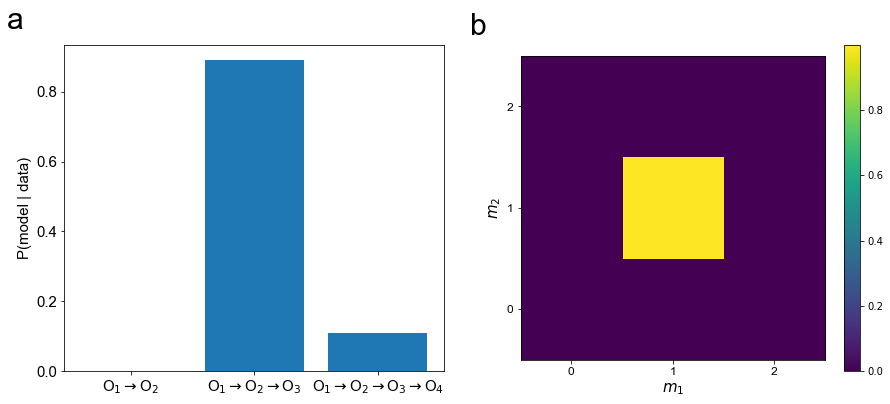

In [114]:
evid_sum = evids_1[-1] + evids_2[-1] + evids_3[-1]
evids_norm = np.array([evids_1[-1], evids_2[-1], evids_3[-1]])
evids_norm /= evid_sum
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(['O$_1\\rightarrow$O$_2$', 'O$_1\\rightarrow$O$_2\\rightarrow$O$_3$', 'O$_1\\rightarrow$O$_2\\rightarrow$O$_3\\rightarrow$O$_4$'], evids_norm)
plt.xticks(fontsize=15, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.ylabel('P(model | data)', fontsize=15, fontname='Arial')
plt.text(-1.0, 0.98, 'a', fontsize=30, fontname='Arial')

plt.subplot(1, 2, 2)
plt.imshow(evids.T, origin='lower')
plt.xlabel('$m_1$', fontsize=15)
plt.ylabel('$m_2$', fontsize=15)
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1), minor=False);
ax.set_yticks(np.arange(0, 3, 1), minor=False);
ax.set_xticklabels([0,1,2], fontname='Arial', fontsize=12)
ax.set_yticklabels([0,1,2], fontname='Arial', fontsize=12)
plt.colorbar()
# #     plt.scatter(m_true[draw_idx[0]-3]-1, m_true[draw_idx[1]-3]-1, c='red')
plt.xlim(range_m[0]-0.5, range_m[1]+0.5)
plt.ylim(range_m[0]-0.5, range_m[1]+0.5)
#     plt.scatter(trace['m'][idx, 0], trace['m'][idx, 1], c='orangered')
plt.text(-1.0, 2.7, 'b', fontsize=30, fontname='Arial')
# plt.savefig('chromium_m_evid_350nm_fixR.pdf', bbox_inches='tight')
plt.savefig('./model_compare_350nm_fixR_randomM.pdf', bbox_inches='tight')

In [7]:
evids[2][1]

3.799542167271251e-12

In [78]:
@as_op(itypes=[tt.dvector], 
       otypes=[tt.dvector])
def get_spectra(k_log):
    r7 = 1 / 3.0
    k1_log, k2_log = k_log
    m1, m2 = [1, 1]
    spectra = np.array([])
    for k in range(n_set):
        species = get_species_analy(k1_log, k2_log, m1, m2, r7, init_cs[k], n_datas[k])
    #     sp = np.c_[sp_O1, sp_O2, sp_O3].T
    #     spectra = species[:, :3].dot(sp)
        Cr = species[:, -1]
        tf = (Cr >= cs_Cr[1]).astype(int)
        sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
        spectra = np.append(spectra, sp_Cr.flatten())
    
    return spectra

@as_op(itypes=[tt.dvector], otypes=[tt.dvector])
def get_spectra_noise(g):
    return noise_scale_base + noise_scale_ratio * np.abs(g)

In [79]:
with pm.Model() as model:
    k_log = pm.Uniform('k_log', *range_k_log, shape=2)
#     m = pm.DiscreteUniform('m', *range_m, shape=2)
#     m = [1, 1]
#     m = pm.Categorical('m', np.ones(len(range_m)) / len(range_m), shape=3)
#     m = pm.Bernoulli('m', 0.5, shape=3)
#     sp_O1 = pm.Uniform('sp_O1', 0, 3, shape=len(idxs))
#     sp_O2 = pm.Uniform('sp_O2', 0, 3, shape=len(idxs))
#     sp_O3 = pm.Uniform('sp_O3', 0, 3, shape=len(idxs))
    g = get_spectra(k_log)
    sigma = get_spectra_noise(g)
    y = pm.Normal('y', mu=g, sd=sigma, observed=data)
#     step1 = pm.Metropolis([k_log,Esep])
#     step2 = pm.BinaryMetropolis([m])
    step = pm.Metropolis()
    trace = pm.sample(draws=10000, cores=6, chains=6, tune=10000, step=step, random_seed=0)

Multiprocess sampling (6 chains in 6 jobs)
Metropolis: [k_log]
Sampling 6 chains, 0 divergences: 100%|██████████| 120000/120000 [00:26<00:00, 4471.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [80]:
# @as_op(itypes=[tt.dvector, tt.lvector, tt.dscalar], 
#        otypes=[tt.dvector])
def get_spectra(k_log, m, r7):
    k1_log, k2_log = k_log
    m1, m2 = m
    spectra = np.array([])
    for k in range(n_set):
        species = get_species_analy(k1_log, k2_log, m1, m2, r7, init_cs[k], n_datas[k])
    #     sp = np.c_[sp_O1, sp_O2, sp_O3].T
    #     spectra = species[:, :3].dot(sp)
        Cr = species[:, -1]
        tf = (Cr >= cs_Cr[1]).astype(int)
        sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
        spectra = np.append(spectra, sp_Cr.flatten())
    
    return spectra

# @as_op(itypes=[tt.dvector], otypes=[tt.dvector])
def get_spectra_noise(g):
    return noise_scale_base + noise_scale_ratio * np.abs(g)

def get_log_prior(k_log, m, r7):
    return 0

logps = np.zeros(len(trace['k_log']))
for i in trange(len(logps)):
    spectrum = get_spectra(trace['k_log'][i], 
                           [1, 1], 
                           1 / 3.0)
    sigma = get_spectra_noise(spectrum)
    logps[i] = normlogpdf(spectrum, data, sigma).sum() + get_log_prior(trace['k_log'][i], [1,1], 1 / 3)

100%|██████████| 60000/60000 [00:31<00:00, 1934.06it/s]


In [81]:
idx = np.argmax(logps)
print(trace['k_log'][idx][0], trace['k_log'][idx][1])
# print(trace['m'][idx])
# print(trace['r7'][idx])

4.5722424066679475 3.2876921199845137


In [82]:
10 **(4.576098184169286 - 8)

0.00037678897282865143

In [83]:
10 ** (3.2979744007610874 - 8)

1.985977851582882e-05

In [76]:
tmp = np.r_[trace['k_log'][:10000], trace['k_log'][20000:]]
tmp = 10 ** (tmp - 8)

In [78]:
tmp[:, 1].std()

2.677972884987595e-07

In [113]:
plt.rcParams['font.family'] = 'Arial'

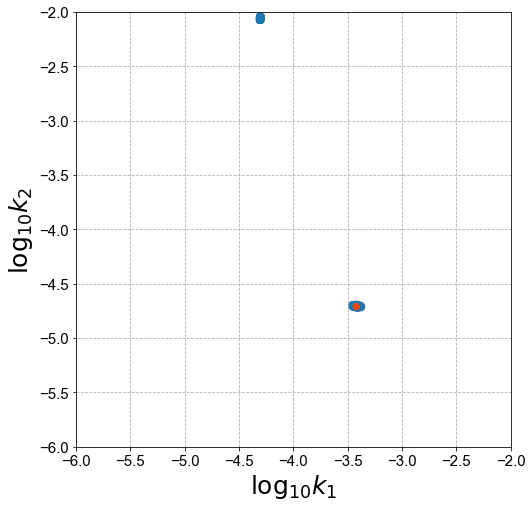

In [114]:
np.set_printoptions(precision=2)
para_name = ['$\log_{10}k_1$', 
             '$\log_{10}k_2$', 
             '$m_1$', '$m_2$']
k_log_true = [k1_log_true[0], k2_log_true[0]]
m_true = [m1_true[0], m2_true[0]]
# k_log
draw_idxs = [[0,1]]
plt.figure(figsize=(10,8))
for i, draw_idx in enumerate(draw_idxs):
    plt.subplot(1, 1, i+1, aspect='equal')
    plt.scatter(trace['k_log'][:, 0] - 8, trace['k_log'][:, 1] - 8, alpha=0.01)
    plt.scatter(trace['k_log'][idx, 0] - 8, trace['k_log'][idx, 1] - 8, alpha=1, c='orangered')
    plt.xlabel(para_name[draw_idx[0]], fontsize=25)
    plt.ylabel(para_name[draw_idx[1]], fontsize=25)
    if i==1: plt.title('SOC={}'.format(SOC), fontsize=20, y=1.01)
#     plt.colorbar(format='%.1f')
#     plt.scatter(k_log_true[draw_idx[0]], k_log_true[draw_idx[1]], c='red')
    plt.xlim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.ylim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.grid(ls='--')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
# plt.savefig('chromium_k_post_350nm_fixR_M11.png', bbox_inches='tight')

In [105]:
np.log10(3.34e-5)

-4.476253533188435

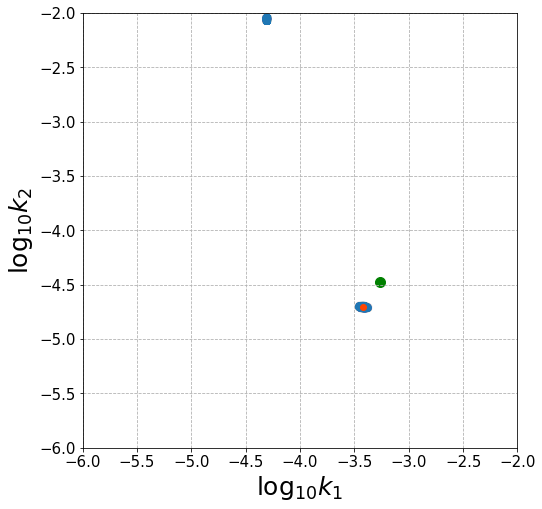

In [106]:
np.set_printoptions(precision=2)
para_name = ['$\log_{10}k_1$', 
             '$\log_{10}k_2$', 
             '$m_1$', '$m_2$']
k_log_true = [k1_log_true[0], k2_log_true[0]]
m_true = [m1_true[0], m2_true[0]]
# k_log
draw_idxs = [[0,1]]
plt.figure(figsize=(10,8))
for i, draw_idx in enumerate(draw_idxs):
    plt.subplot(1, 1, i+1, aspect='equal')
    plt.scatter(trace['k_log'][:, 0] - 8, trace['k_log'][:, 1] - 8, alpha=0.01)
    plt.scatter(trace['k_log'][idx, 0] - 8, trace['k_log'][idx, 1] - 8, alpha=1, c='orangered')
#     plt.scatter(-3.268, -4.476, alpha=1, c='green', s=100)
    plt.scatter(-3.267, -4.476, alpha=1, c='green', s=100)
    plt.xlabel(para_name[draw_idx[0]], fontsize=25)
    plt.ylabel(para_name[draw_idx[1]], fontsize=25)
    if i==1: plt.title('SOC={}'.format(SOC), fontsize=20, y=1.01)
#     plt.colorbar(format='%.1f')
#     plt.scatter(k_log_true[draw_idx[0]], k_log_true[draw_idx[1]], c='red')
    plt.xlim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.ylim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.grid(ls='--')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
# plt.savefig('chromium_k_post_350nm_fixR_M11.png', bbox_inches='tight')

In [86]:
n_grid = 301
k_log_grid = np.linspace(*range_k_log, n_grid)
K_log_X, K_log_Y = np.meshgrid(k_log_grid, k_log_grid, indexing='ij')
logP = np.zeros(K_log_X.shape)
for i in trange(n_grid):
    for j in range(n_grid):
        k_log_x = K_log_X[i, j]
        k_log_y = K_log_Y[i, j]
        spectrum = get_spectra([k_log_x, k_log_y], 
                           [1, 1], 
                           1 / 3.0)
        sigma = get_spectra_noise(spectrum)
        logP[i, j] = normlogpdf(spectrum, data, sigma).sum() + get_log_prior([k_log_x, k_log_y], [1,1], 1 / 3)

100%|██████████| 301/301 [00:34<00:00,  8.81it/s]


In [17]:
np.where(logP == logP.max())

(array([193]), array([97]))

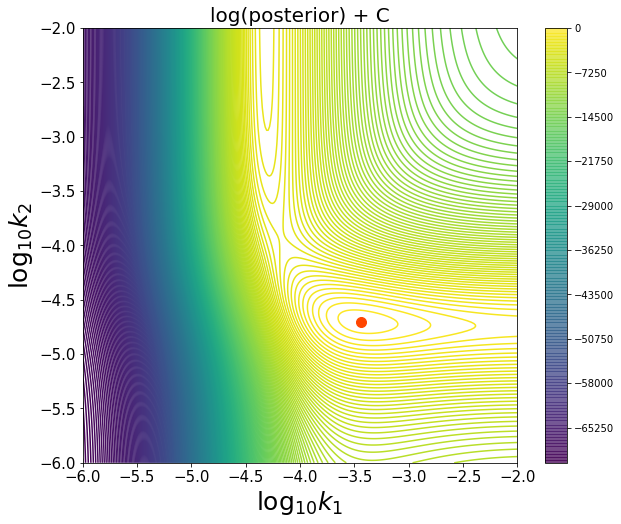

In [30]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 1, 1, aspect='equal')
plt.contour(K_log_X - 8, K_log_Y - 8, logP, levels=300)
plt.colorbar()
plt.scatter(k_log_grid[192] - 8, k_log_grid[97] - 8, c='orangered', s=100)
plt.title('log(posterior) + C', fontsize=20)
plt.xlabel('$\log_{10}k_1$', fontsize=25)
plt.ylabel('$\log_{10}k_2$', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('chromium_k_post_contour_350nm_fixR_M11.png', bbox_inches='tight')

Text(0, 0.5, '$\\log_{10}k_2$')

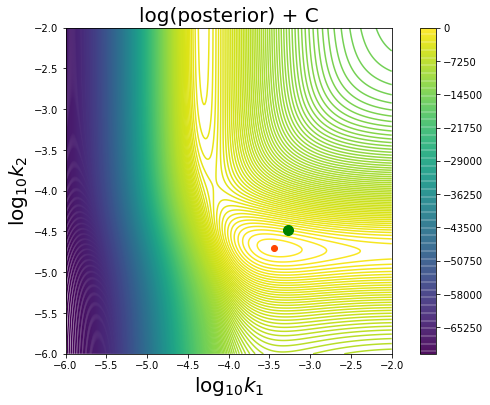

In [107]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1, aspect='equal')
plt.contour(K_log_X - 8, K_log_Y - 8, logP, levels=300)
plt.colorbar()
plt.scatter(k_log_grid[192] - 8, k_log_grid[97] - 8, c='orangered')
plt.scatter(-3.267, -4.476, alpha=1, c='green', s=100, zorder=10)
plt.title('log(posterior) + C', fontsize=20)
plt.xlabel('$\log_{10}k_1$', fontsize=20)
plt.ylabel('$\log_{10}k_2$', fontsize=20)

In [115]:
np.log10((4.65 + 5.6 + 4.6) / 3 * 10 ** -4)

-3.305394801066431

In [116]:
np.log10((1.06 + 1.07 + 2.07) / 3 * 10 ** -5)

-4.853871964321762

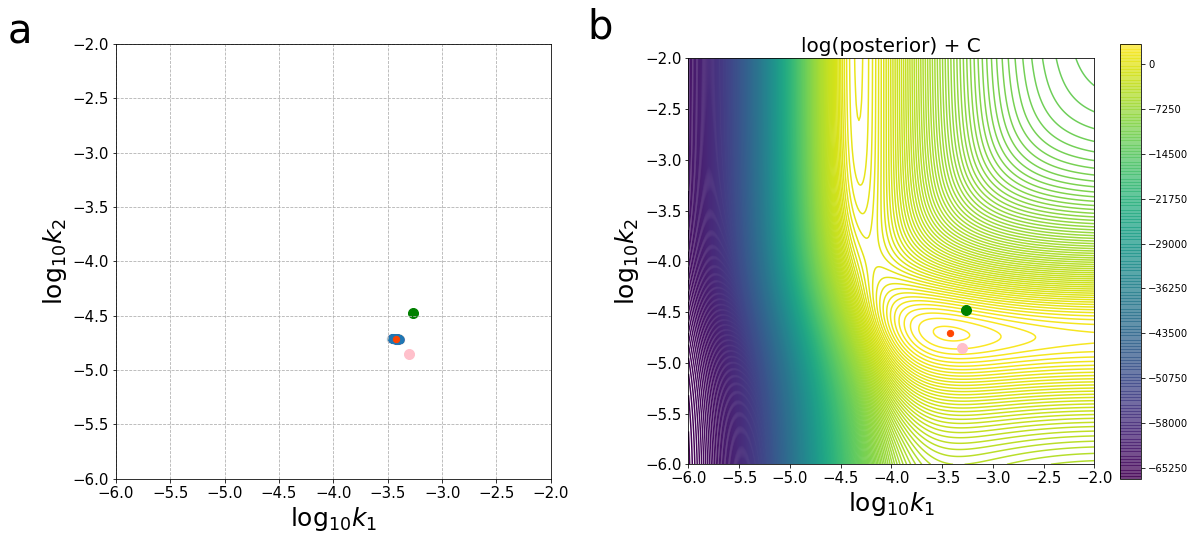

In [117]:
plt.figure(figsize=(20, 8))
para_name = ['$\log_{10}k_1$', 
             '$\log_{10}k_2$', 
             '$m_1$', '$m_2$']
k_log_true = [k1_log_true[0], k2_log_true[0]]
m_true = [m1_true[0], m2_true[0]]
# k_log
draw_idxs = [[0,1]]
for i, draw_idx in enumerate(draw_idxs):
    plt.subplot(1, 2, i+1, aspect='equal')
    plt.scatter(trace['k_log'][:, 0] - 8, trace['k_log'][:, 1] - 8, alpha=0.01)
    plt.scatter(trace['k_log'][idx, 0] - 8, trace['k_log'][idx, 1] - 8, alpha=1, c='orangered', s=40)
#     plt.scatter(-3.268, -4.476, alpha=1, c='green', s=100)
    plt.scatter(-3.267, -4.476, alpha=1, c='green', s=100)
    plt.scatter(-3.305, -4.854, alpha=1, c='pink', s=100)
    plt.xlabel(para_name[draw_idx[0]], fontsize=25)
    plt.ylabel(para_name[draw_idx[1]], fontsize=25)
    if i==1: plt.title('SOC={}'.format(SOC), fontsize=20, y=1.01)
#     plt.colorbar(format='%.1f')
#     plt.scatter(k_log_true[draw_idx[0]], k_log_true[draw_idx[1]], c='red')
    plt.xlim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.ylim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.grid(ls='--')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.text(-7, -2, 'a', fontsize=40)
plt.subplot(1, 2, 2, aspect='equal')
plt.contour(K_log_X - 8, K_log_Y - 8, logP, levels=300)
plt.colorbar()
plt.scatter(k_log_grid[193] - 8, k_log_grid[97] - 8, c='orangered', s=40)
plt.scatter(-3.267, -4.476, alpha=1, c='green', s=100, zorder=10)
plt.scatter(-3.305, -4.854, alpha=1, c='pink', s=100, zorder=10)
plt.title('log(posterior) + C', fontsize=20)
plt.xlabel('$\log_{10}k_1$', fontsize=25)
plt.ylabel('$\log_{10}k_2$', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(-7, -1.8, 'b', fontsize=40)
plt.savefig('chromium_k_post_350nm_fixR_M11.png', bbox_inches='tight')

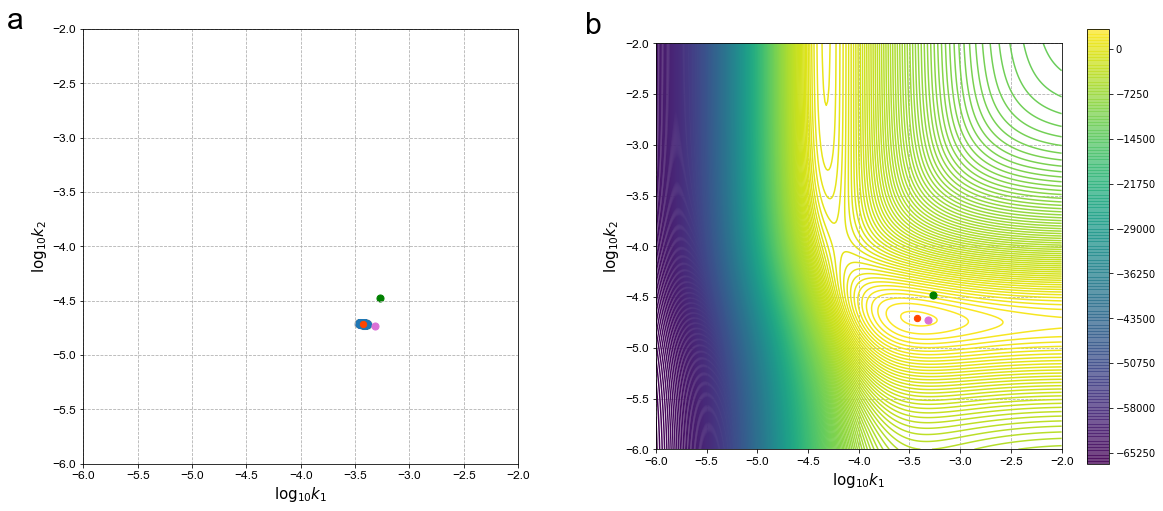

In [177]:
plt.figure(figsize=(20, 8))
para_name = ['$\log_{10}k_1$', 
             '$\log_{10}k_2$', 
             '$m_1$', '$m_2$']
k_log_true = [k1_log_true[0], k2_log_true[0]]
m_true = [m1_true[0], m2_true[0]]
# k_log
draw_idxs = [[0,1]]
for i, draw_idx in enumerate(draw_idxs):
    plt.subplot(1, 2, i+1, aspect='equal')
    plt.scatter(trace['k_log'][:, 0] - 8, trace['k_log'][:, 1] - 8, alpha=0.01)
    plt.scatter(trace['k_log'][idx, 0] - 8, trace['k_log'][idx, 1] - 8, alpha=1, c='orangered', s=40)
#     plt.scatter(-3.268, -4.476, alpha=1, c='green', s=100)
    plt.scatter(-3.267, -4.476, alpha=1, c='green', s=50)
    plt.scatter(-3.32, -4.73, alpha=1, c='orchid', s=50)
    plt.xlabel(para_name[draw_idx[0]], fontsize=15, fontname='Arial')
    plt.ylabel(para_name[draw_idx[1]], fontsize=15, fontname='Arial')
    if i==1: plt.title('SOC={}'.format(SOC), fontsize=20, y=1.01)
#     plt.colorbar(format='%.1f')
#     plt.scatter(k_log_true[draw_idx[0]], k_log_true[draw_idx[1]], c='red')
    plt.xlim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.ylim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.grid(ls='--')
    plt.xticks(fontsize=12, fontname='Arial')
    plt.yticks(fontsize=12, fontname='Arial')
plt.text(-6.7, -2, 'a', fontsize=30, fontname='Arial')
plt.subplot(1, 2, 2, aspect='equal')
plt.contour(K_log_X - 8, K_log_Y - 8, logP, levels=300)
plt.colorbar()
plt.scatter(k_log_grid[193] - 8, k_log_grid[97] - 8, c='orangered', s=40)
plt.scatter(-3.267, -4.476, alpha=1, c='green', s=50, zorder=10)
plt.scatter(-3.32, -4.73, alpha=1, c='orchid', s=50, zorder=10)
# plt.title('log(unnormalized posterior)', fontsize=15, fontname='Arial')
plt.xlabel('$\log_{10}k_1$', fontsize=15, fontname='Arial')
plt.ylabel('$\log_{10}k_2$', fontsize=15, fontname='Arial')
plt.xticks(fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.text(-6.7, -1.9, 'b', fontsize=30, fontname='Arial')
plt.grid(ls='--')
plt.savefig('chromium_k_post_350nm_fixR_M11.png', bbox_inches='tight')

In [38]:
(10 ** (trace['k_log'][20000:] - 8)).std(axis=0)[1]

2.6838358689662007e-07

In [45]:
logps[10000:20000]

array([-2110.35, -2108.96, -2108.96, ..., -2108.94, -2108.94, -2108.74])

In [46]:
logps

array([-80.93, -80.25, -80.25, ..., -80.32, -80.32, -80.32])

In [14]:
trace['k_log'].mean(axis=0), 

(array([4.43, 3.74]),)

In [15]:
trace['k_log'].std(axis=0)[0], trace['k_log'].std(axis=0)[1]

(0.3307279448473203, 0.9943746576739199)

In [16]:
# # m
# draw_idxs = [[2,3]]
# plt.figure(figsize=(20,5))
# for i, draw_idx in enumerate(draw_idxs):
#     plt.subplot(1, 3, i+1)
#     post_draw = np.zeros((3, 3))
#     for tmp in trace['m']:
#         post_draw[tmp[0], tmp[1]] += 1
#     post_draw /= post_draw.sum()
#     plt.imshow(post_draw.T, origin='lower')
#     plt.xlabel(para_name[draw_idx[0]], fontsize=20)
#     plt.ylabel(para_name[draw_idx[1]], fontsize=20)
#     ax = plt.gca()
#     ax.set_xticks(np.arange(0, 3, 1), minor=False);
#     ax.set_yticks(np.arange(0, 3, 1), minor=False);
#     ax.set_xticklabels([0,1,2])
#     ax.set_yticklabels([0,1,2])
#     plt.colorbar()
# #     plt.scatter(m_true[draw_idx[0]-3]-1, m_true[draw_idx[1]-3]-1, c='red')
#     plt.xlim(range_m[0]-0.5, range_m[1]+0.5)
#     plt.ylim(range_m[0]-0.5, range_m[1]+0.5)
#     plt.scatter(trace['m'][idx, 0], trace['m'][idx, 1], c='orangered')
# plt.savefig('chromium_m_post_445nm_fixR_randomM.pdf', bbox_inches='tight')

In [ ]:
n_datas

In [83]:
dt

300

In [85]:
24 * 3600 / 300

288.0

In [89]:
# generate samples from posterior
n_sample = 1000
sample_idxs = np.random.choice(len(trace['k_log']), n_sample, replace=False)
k1_samples = trace['k_log'][sample_idxs, 0]
k2_samples = trace['k_log'][sample_idxs, 1]
# m1_samples = trace['m'][sample_idxs, 0]
# m2_samples = trace['m'][sample_idxs, 1]
# r7_samples = trace['r7'][sample_idxs]
data_samples = np.zeros((len(data), n_sample))
species_mu = []
species_sigma = []
for k in range(n_set):
    species_samples = []
    for i in range(n_sample):
        k1, k2 = k1_samples[i], k2_samples[i]
        m1, m2 = 1, 1
        r7 = 1 / 3
        species = get_species(k1, k2, m1, m2, r7, init_cs[k], 288)
        species_samples.append(species)
    species_mu.append(np.mean(species_samples, axis=0))
    species_sigma.append(np.std(species_samples, axis=0))

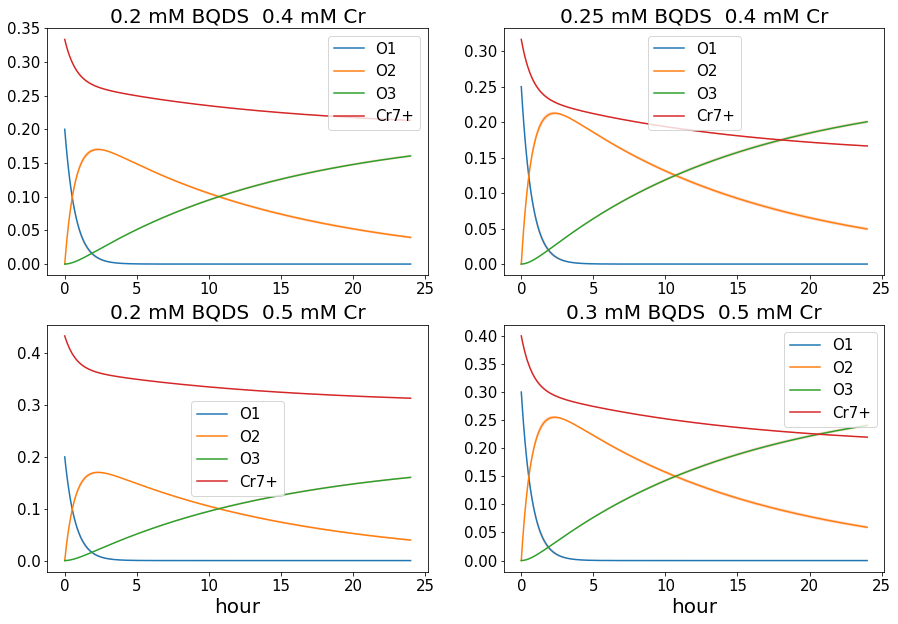

In [149]:
names = ['O1', 'O2', 'O3', 'Cr7+']
plt.figure(figsize=(15, 10))
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    for i in range(4):
        mu = species_mu[k][:, i]
        sigma = species_sigma[k][:, i]
        plt.plot(time, mu, label=names[i])
        plt.fill(np.concatenate([time, time[::-1]]), 
                 np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
                 alpha=.2, fc='orangered', ec='None')
    plt.legend(fontsize=15)
    if k > 1:
        plt.xlabel('hour', fontsize=20)
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
# plt.savefig('./chromium_evolution_445nm_fixR_randomM.pdf', bbox_inches='tight')

In [63]:
trace['k_log'][idx]

array([4.58, 3.3 ])

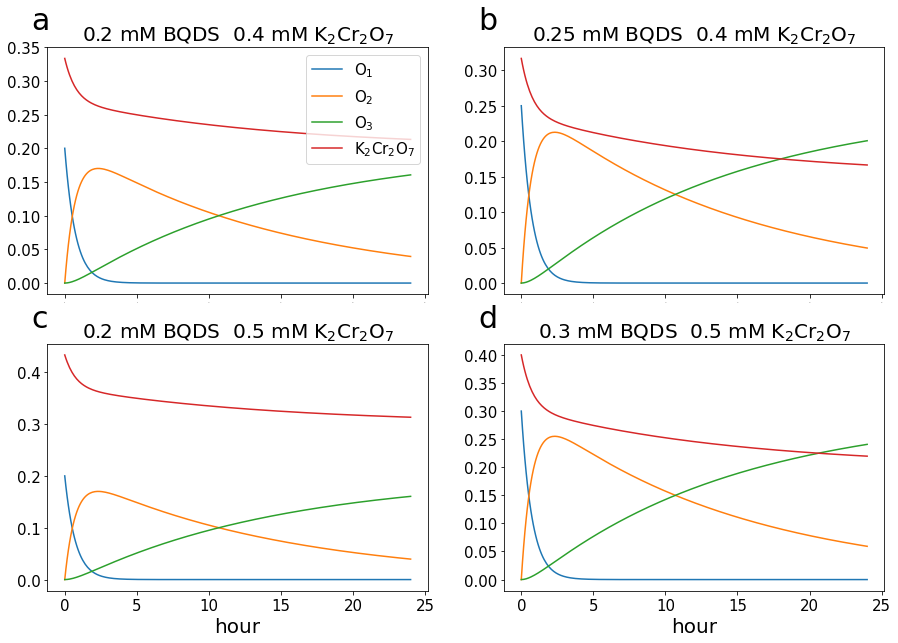

In [90]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(15, 10))
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    if k == 0:
        plt.legend(fontsize=15)
    if k > 1:
        plt.xlabel('hour', fontsize=20)
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20)
    if k > 1:
        plt.xticks(fontsize=15)
    else:
        plt.xticks(fontsize=0)
    plt.yticks(fontsize=15)
plt.text(-34, 0.98, 'a', fontsize=30)
plt.text(-3, 0.98, 'b', fontsize=30)
plt.text(-34, 0.45, 'c', fontsize=30)
plt.text(-3, 0.45, 'd', fontsize=30)

plt.savefig('./chromium_evolution_350nm_fixR_M11.pdf', bbox_inches='tight')

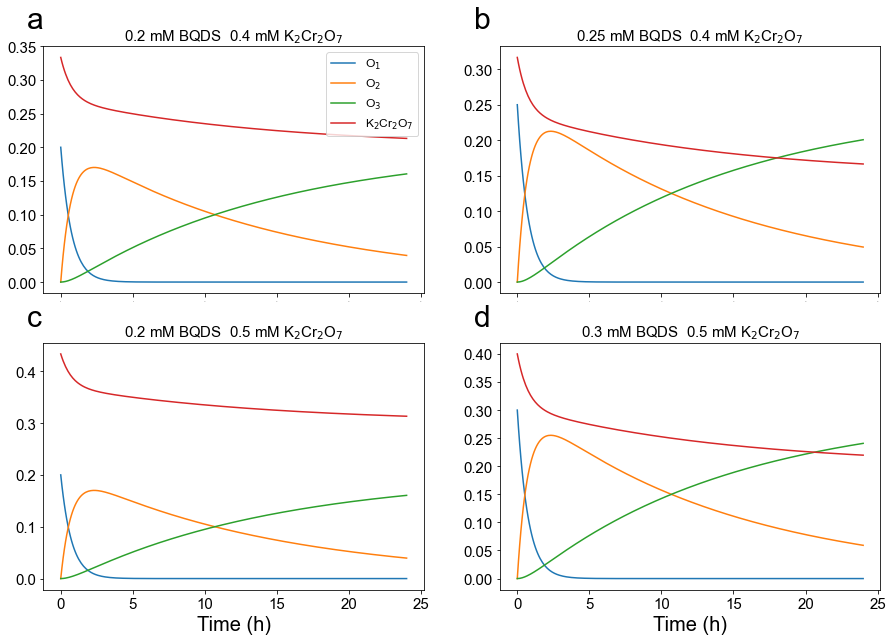

In [145]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(15, 10))
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    if k == 0:
        plt.legend(prop={'family':'Arial', 'size':12})
    if k > 1:
        plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=15, fontname='Arial')
    if k > 1:
        plt.xticks(fontsize=15, fontname='Arial')
    else:
        plt.xticks(fontsize=0)
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-34, 0.98, 'a', fontsize=30, fontname='Arial')
plt.text(-3, 0.98, 'b', fontsize=30, fontname='Arial')
plt.text(-34, 0.45, 'c', fontsize=30, fontname='Arial')
plt.text(-3, 0.45, 'd', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_350nm_fixR_M11.pdf', bbox_inches='tight')

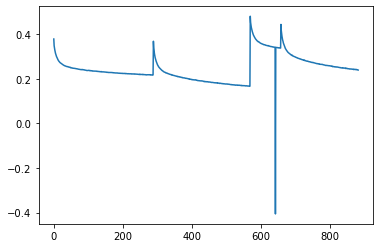

In [70]:
plt.plot(data)

In [71]:
data[643] = (data[642] + data[644]) / 2.0

In [92]:
consumed_crs = []
crs = data.copy()
for k in range(n_set):
    Cr = crs[:n_datas[k]+1]
    crs = crs[n_datas[k]+1:]
    tf = (Cr >= cs_Cr[1]).astype(int)
    sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
    sp_Cr = sp_Cr.flatten()
    consumed_cr = (init_cs[k][1] - sp_Cr) * 0.2 / init_cs[k][0]
    consumed_crs.append(consumed_cr)

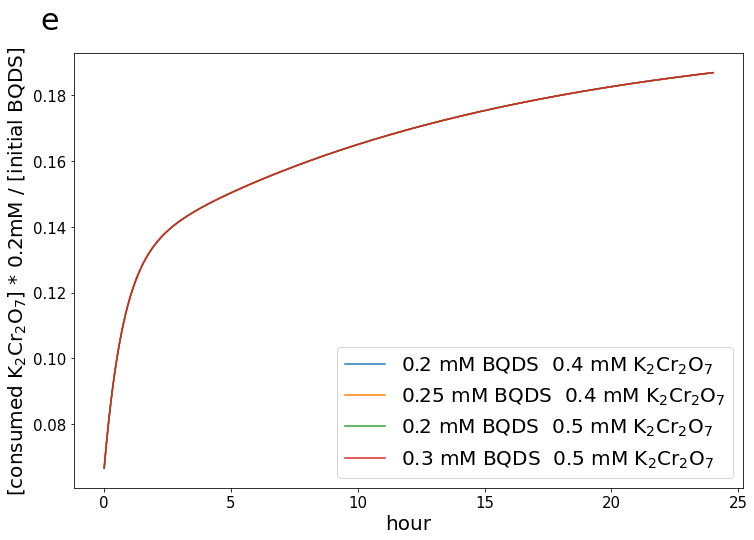

In [93]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
plt.figure(figsize=(12, 8))
for k in range(n_set):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$')
plt.legend(fontsize=20)
plt.xlabel('hour', fontsize=20)
plt.ylabel('[consumed K$_{2}$Cr$_{2}$O$_{7}$] * 0.2mM / [initial BQDS]', fontsize=20)
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(-2.5, 0.2, 'e', fontsize=30)
plt.savefig('./chromium_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')

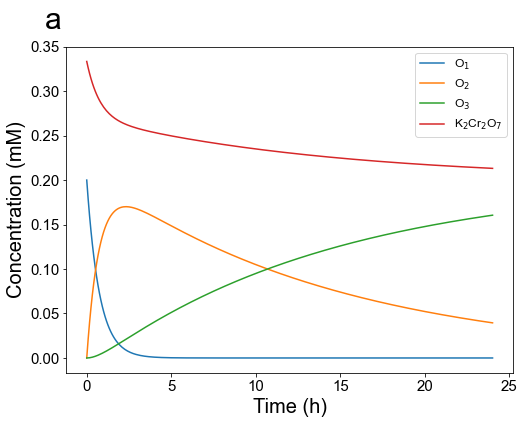

In [163]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(8, 6))
for k in range(1):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    plt.legend(prop={'family':'Arial', 'size':12})
    plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.ylabel('Concentration (mM)', fontsize=20, fontname='Arial')
#     plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=15, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.37, 'a', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_350nm_fixR_M11_a.pdf', bbox_inches='tight')

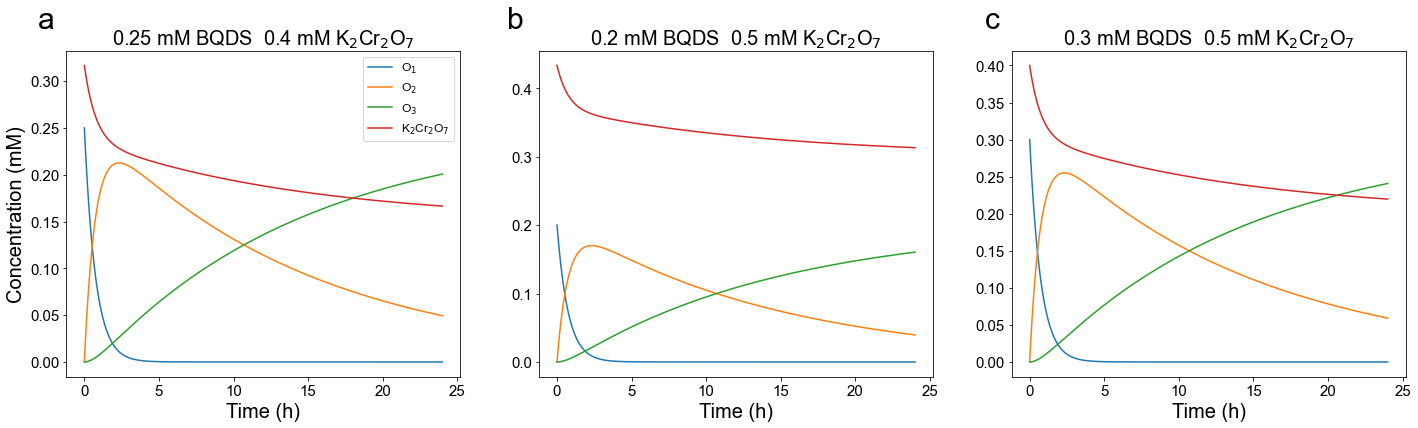

In [173]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(24, 6))
for k in range(1, n_set):
    plt.subplot(1, 3, k)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    if k == 1:
        plt.legend(prop={'family':'Arial', 'size':12})
        plt.ylabel('Concentration (mM)', fontsize=20, fontname='Arial')
    plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-66.5, 0.45, 'a', fontsize=30, fontname='Arial')
plt.text(-35, 0.45, 'b', fontsize=30, fontname='Arial')
plt.text(-3, 0.45, 'c', fontsize=30, fontname='Arial')
# plt.text(-3, 0.45, 'd', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_350nm_fixR_M11_bcd.pdf', bbox_inches='tight')

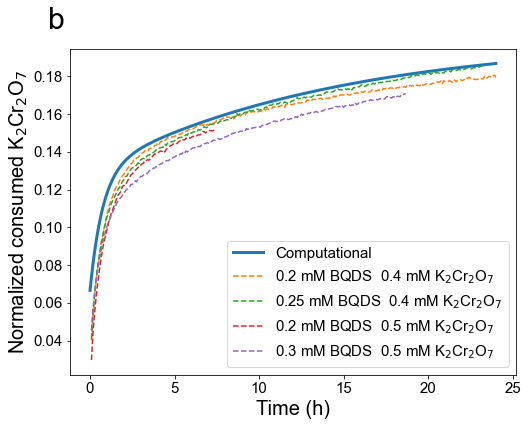

In [164]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
plt.figure(figsize=(8, 6))
k = 0
time = np.arange(len(species_mu[k])) * dt / 3600
species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
         label='Computational', lw=3)
for k in range(n_set):
    time = np.arange(n_datas[k] + 1) * dt / 3600
    species = consumed_crs[k]
    plt.plot(time[1:], species[1:], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', ls='--')
plt.legend(prop={'family':'Arial', 'size':15})
plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
# plt.ylabel('[consumed K$_{2}$Cr$_{2}$O$_{7}$] * 0.2mM / [initial BQDS]', fontsize=20, fontname='Arial')
plt.ylabel('Normalized consumed K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20, fontname='Arial')
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.205, 'b', fontsize=30, fontname='Arial')
plt.savefig('./chromium_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')

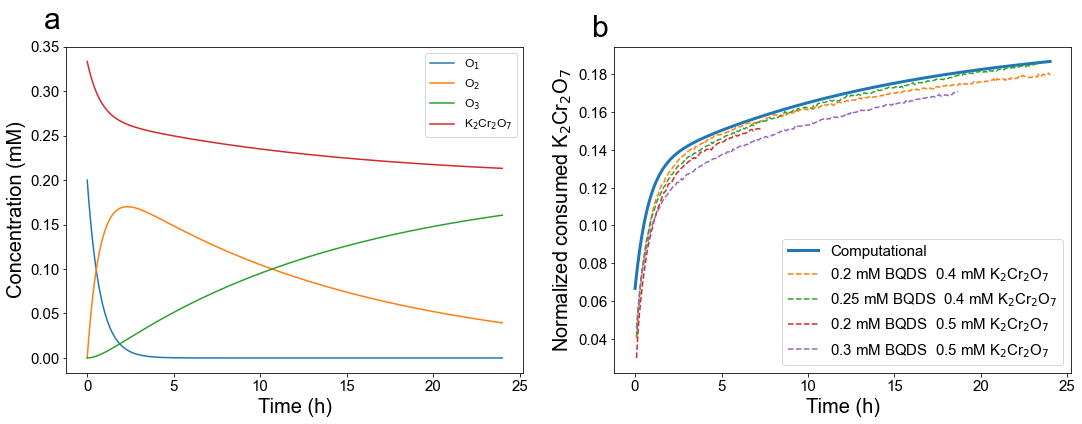

In [186]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for k in range(1):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    plt.legend(prop={'family':'Arial', 'size':12})
    plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.ylabel('Concentration (mM)', fontsize=20, fontname='Arial')
#     plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=15, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.37, 'a', fontsize=30, fontname='Arial')

plt.subplot(1, 2, 2)
k = 0
time = np.arange(len(species_mu[k])) * dt / 3600
species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
         label='Computational', lw=3)
for k in range(n_set):
    time = np.arange(n_datas[k] + 1) * dt / 3600
    species = consumed_crs[k]
    plt.plot(time[1:], species[1:], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', ls='--')
plt.legend(prop={'family':'Arial', 'size':15})
plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
# plt.ylabel('[consumed K$_{2}$Cr$_{2}$O$_{7}$] * 0.2mM / [initial BQDS]', fontsize=20, fontname='Arial')
plt.ylabel('Normalized consumed K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20, fontname='Arial')
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.20, 'b', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')

In [ ]:

plt.figure(figsize=(20, 8))
names = ['O1', 'O2', 'O3', 'Cr7+']
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], n_datas[k])
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    plt.legend(fontsize=15)
    if k > 1:
        plt.xlabel('hour', fontsize=20)
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
names = ['O1', 'O2', 'O3', 'Cr7+']
plt.figure(figsize=(12, 8))
for k in range(n_set):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], n_datas[k])
    plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr')
plt.legend(fontsize=15)
plt.xlabel('hour', fontsize=20)
plt.ylabel('[consumed chromium] * 0.2mM / [BQDS]', fontsize=20)
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./chromium_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')
plt.savefig('./chromium_evolution_350nm_fixR_M11.pdf', bbox_inches='tight')

In [37]:
# generate samples from posterior
n_sample = 1000
sample_idxs = np.random.choice(len(trace['k_log']), n_sample, replace=False)
k1_samples = trace['k_log'][sample_idxs, 0]
k2_samples = trace['k_log'][sample_idxs, 1]
m1_samples = trace['m'][sample_idxs, 0]
m2_samples = trace['m'][sample_idxs, 1]
r7_samples = trace['r7'][sample_idxs]
k = 0
data_samples = np.zeros(((n_datas[k] + 1) * len(idxs), n_sample))
species_samples = []
for i in range(n_sample):
    k1, k2 = k1_samples[i], k2_samples[i]
    m1, m2 = m1_samples[i], m2_samples[i]
#     sp_O1, sp_O2, sp_O3 = sp_O1_samples[i], sp_O2_samples[i], sp_O3_samples[i]
    r7 = r7_samples[i]
    species = get_species_analy(k1, k2, m1, m2, r7, init_cs[k], n_datas[k])
    species_samples.append(species)
#     sp = np.c_[sp_O1, sp_O2, sp_O3].T
#     spectrum = species[:, :3].dot(sp) * 0
    Cr = species[:, -1]
    tf = (Cr >= cs_Cr[1]).astype(int)
    sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
    spectrum = sp_Cr
    data_samples[:, i] = spectrum.flatten()
data_mu = data_samples.mean(axis=1).reshape(n_datas[k] + 1, -1)
data_sigma = data_samples.std(axis=1).reshape(n_datas[k] + 1, -1)

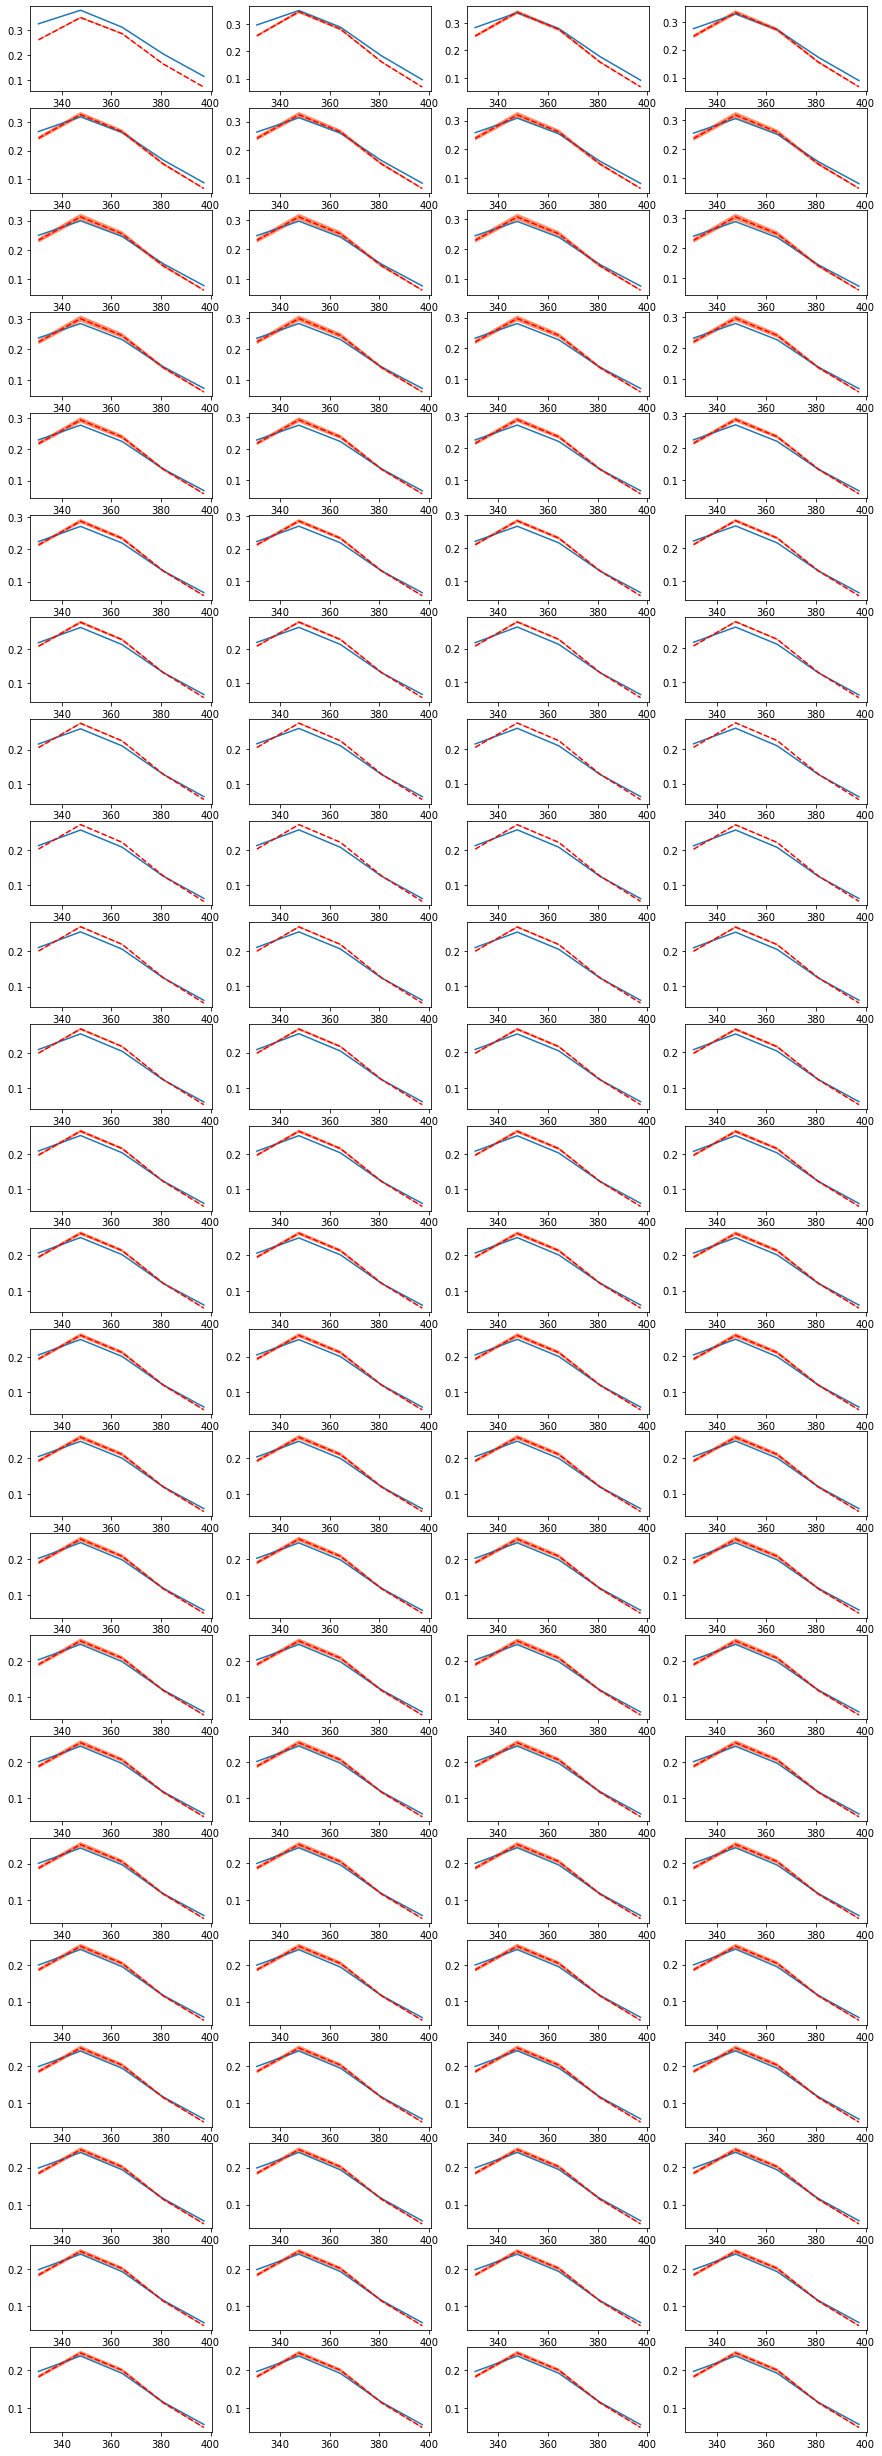

In [38]:
plt.figure(figsize=(15, 200))
for i in range(n_datas[k]//3):
    plt.subplot(107, 4, i + 1)
    plt.plot(spectras[k][i, idxs, 0], spectras[k][i, idxs, 1], label='{:.3} hrs'.format((i+1)/6.0))
    x = spectra[i, idxs, 0]
    mu = data_mu[i]
    sigma = data_sigma[i]
    plt.plot(x, mu, '--', c='red')
    plt.fill(np.concatenate([x, x[::-1]]), 
             np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
             alpha=.6, fc='orangered', ec='None')
#     plt.legend()

In [44]:
from scipy import stats
np.max(stats.t.rvs(500, size=10000))

4.066310199109568

In [15]:
range_k_log

[2, 6]

In [115]:
n_grid = 51
logk_grid = np.linspace(*range_k_log, n_grid)
r7_grid = np.linspace(range_r[0] - 5 * range_r[1], range_r[0] + 5 * range_r[1], n_grid)
X, Y, Z = np.meshgrid(logk_grid, logk_grid, r7_grid, indexing='ij')
X = X.flatten()
Y = Y.flatten()
Z = Z.flatten()
logp_grid = np.zeros(len(X))

for i in trange(len(logp_grid)):
    spectrum = get_spectra([X[i], Y[i]], 
                           [1, 1], 
                           Z[i])
    sigma = get_spectra_noise(spectrum)
    logp_grid[i] = normlogpdf(spectrum, data, sigma).sum() + get_log_prior([X[i], Y[i]], [1, 1], Z[i])

100%|██████████| 132651/132651 [00:53<00:00, 2493.54it/s]


In [116]:
logp_grid = logp_grid.reshape(n_grid, n_grid, n_grid)
p_grid = np.exp(logp_grid).reshape(n_grid, n_grid, n_grid)
X = X.reshape(n_grid, n_grid, n_grid)
Y = Y.reshape(n_grid, n_grid, n_grid)
Z = Z.reshape(n_grid, n_grid, n_grid)

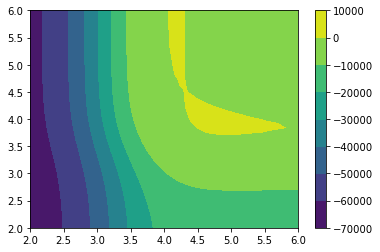

In [117]:
tmp = 1
plt.contourf(X[:, :, tmp], Y[:, :, tmp], logp_grid[:, :, tmp])
plt.colorbar()

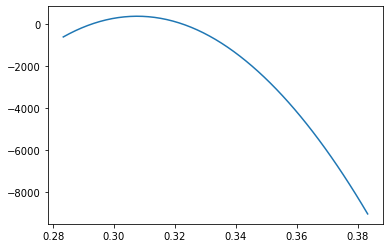

In [118]:
plt.plot(r7_grid, logp_grid[35, 20, :])

In [119]:
logk_grid[32]

4.5600000000000005

In [120]:
logp_grid[:, 50, 50]

array([-39716.88, -38559.94, -37210.83, -35647.4 , -33849.16, -31799.51,
       -29488.83, -26918.27, -24104.48, -21084.66, -17921.37, -14705.99,
       -11559.21,  -8628.84,  -6073.46,  -4042.3 ,  -2659.54,  -1999.22,
        -2065.99,  -2789.75,  -4047.51,  -5685.16,  -7546.94,  -9500.02,
       -11446.82, -13324.55, -15097.11, -16745.38, -18260.47, -19640.01,
       -20886.26, -22005.04, -23004.44, -23893.67, -24682.14, -25378.88,
       -25992.3 , -26530.42, -27000.14, -27408.59, -27762.  , -28066.53,
       -28327.21, -28550.12, -28739.25, -28898.06, -29031.27, -29141.9 ,
       -29232.43, -29304.09, -29359.31])

In [121]:
logp_grid.max()

421.60315849623345

In [124]:
np.where(logp_grid == np.max(logp_grid))

(array([30]), array([13]), array([40]))

In [127]:
Z[30, 13, 40]

0.3633333333333333